In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy.optimize import curve_fit

In [265]:
READFILE = "havforsk.csv"
FISHFILE = 'hi_arter.txt'
ENCODE = "Windows-1252"

# Define the Oslofjord boundaries
OSLOFJORD_LAT_MIN, OSLOFJORD_LAT_MAX  = 58.5, 60.0
OSLOFJORD_LON_MIN, OSLOFJORD_LON_MAX = 10.0, 11.5

#Import Fish Species into a list for later use, sorting it so longest names appear first
fiske_arter: list[str] = []
with open(FISHFILE, 'r', encoding="UTF-8") as file:
	for line in file:
		fiske_arter.append(line.strip())
fiske_arter.sort(key=len)
fiske_arter = fiske_arter[::-1]

#Function for removing multiple substring from a string
def multi_remove(string, to_remove: list[str]|str) -> str:
	string = string.lower()
	if type(string) != str:
		return string
	for symbol in to_remove:
		string = string.replace(symbol, "")
	return string

ukjente_arter: dict[str:int] = {}

#Function to normalize data, trying to put each validSpecie entry into a known Fish Species
def normalize(string: str) -> str:
	if "(" in string:
		string = string[:string.index("(")]
	string = re.sub("[^ÆØÅæøåa-zA-Z]", "", string).lower()
	string = multi_remove(string, ["vanlig", "usikker", "ukjent", "ikkebilde"])
	global fiske_arter
	for art in fiske_arter:
		if art in string:
			return art
	
	global ukjente_arter
	if string in ukjente_arter:
		ukjente_arter[string] = ukjente_arter[string]+1
	else:
		ukjente_arter[string] = 1
	return "annet"

# Function to check if a point is within the Oslofjord area
is_within_oslofjord = lambda lat, lon: OSLOFJORD_LAT_MIN <= lat <= OSLOFJORD_LAT_MAX and OSLOFJORD_LON_MIN <= lon <= OSLOFJORD_LON_MAX


In [266]:
#Create a DataFrame with only the needed columns. 
#Only includes entries where the sighting has been validated
raw_df = pd.read_csv(READFILE, delimiter=";", encoding=ENCODE, engine="python")
df_oslofjord = raw_df[raw_df.apply(lambda row: is_within_oslofjord(row["latitude"], row["longitude"]), axis=1)]
df = df_oslofjord[['date', 'isValidated', 'validSpecie']].dropna(axis="index", inplace=False)
print(df)


                            date  isValidated  \
10    "2019-06-24T00:00:00.000Z"         True   
18    "2019-06-28T01:31:55.209Z"         True   
20    "2019-06-28T06:30:01.757Z"         True   
21    "2019-06-29T19:13:39.291Z"         True   
22    "2019-07-02T00:00:00.000Z"         True   
...                          ...          ...   
3353  "2021-04-24T00:00:00.000Z"         True   
3354  "2023-08-05T00:00:00.000Z"         True   
3355  "2024-08-29T00:00:00.000Z"         True   
3357  "2024-09-01T00:00:00.000Z"         True   
3369  "2024-09-08T00:00:00.000Z"         True   

                                       validSpecie  
10                                      Brennmanet  
18                                         Sjøhare  
20                                      Brennmanet  
21                                      Brennmanet  
22                                      Brennmanet  
...                                            ...  
3353                                    

In [267]:
#Normalize the validSpecie to minimize spelling errors in dataset and remove unnecessary date information
df['validSpecie'] = df['validSpecie'].map(lambda name : normalize(name))
df['year'] = df['date'].map(lambda date: int(date[1:5]))
df.drop(labels="date", axis=1, inplace=True)
print(df)

      isValidated validSpecie  year
10           True       manet  2019
18           True       annet  2019
20           True       manet  2019
21           True       manet  2019
22           True       manet  2019
...           ...         ...   ...
3353         True       annet  2021
3354         True       annet  2023
3355         True       annet  2024
3357         True       manet  2024
3369         True  blekksprut  2024

[564 rows x 3 columns]


                amount
validSpecie           
manet              266
annet              140
krabbe              30
al                  21
hummer              17
østers              16
månefisk            13
lobster             11
blekksprut           7
hai                  5
nise                 4
torsk                4
mulle                3
sild                 3
kreps                3
sjøhest              3
apolemiauvaria       3
kamskjell            2
reke                 2
sverdfisk            2
rognkjeks            2
ulke                 2
brosme               1
hå                   1
havnespy             1
baskingshark         1
steinkobbe           1


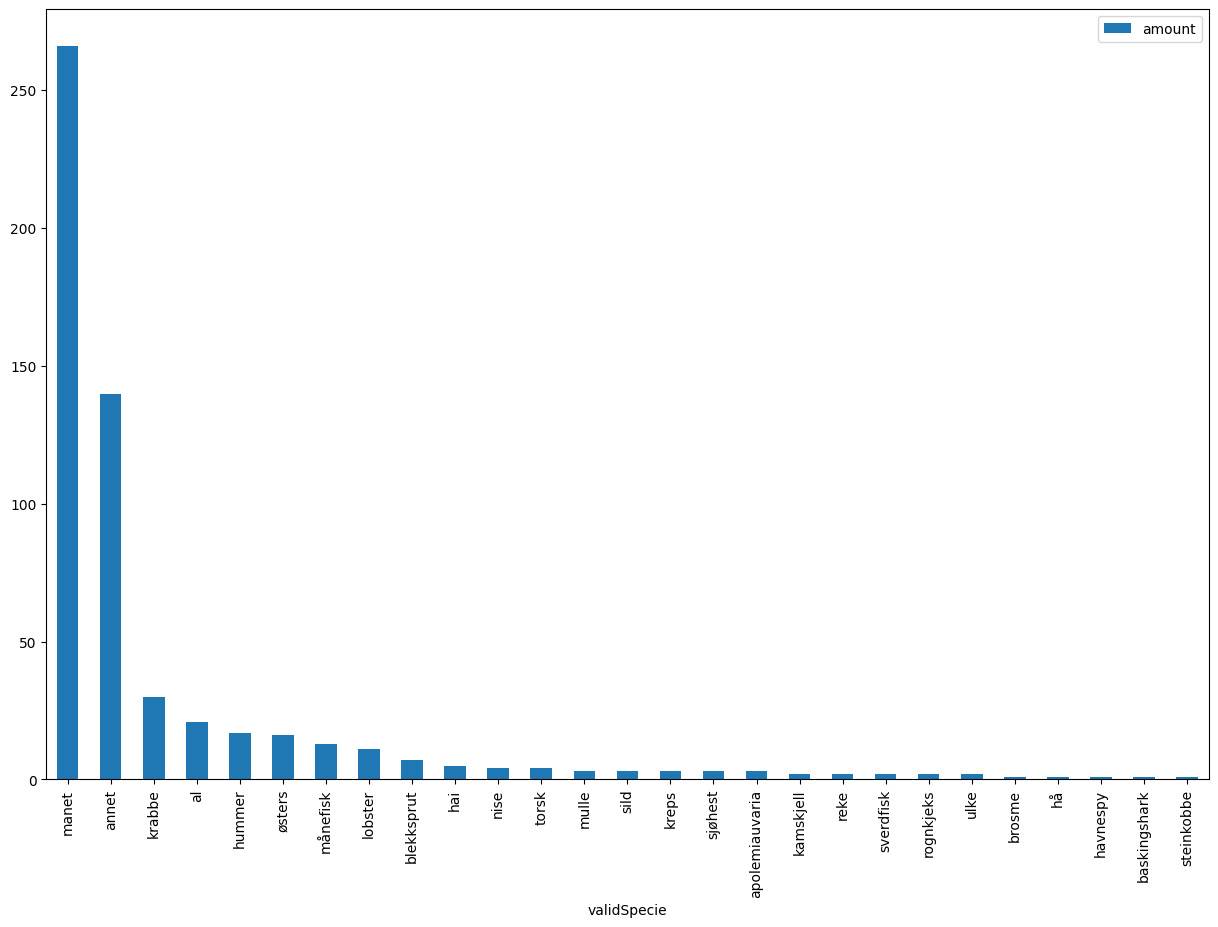

In [268]:
#Group by species and display as a bar graph
species_df = df.groupby(["validSpecie"]).count()
species_df.sort_values(by=['isValidated'], ascending=False,inplace=True)
species_df.rename(columns={"isValidated":"amount"}, inplace=True)
species_df.drop(labels="year", axis=1, inplace=True)
#species_df.reset_index(inplace=True)
print(species_df.head(100))

fig_species, ax_species = plt.subplots(figsize=(15,10))
species_df.plot(kind="bar" ,ax=ax_species)
fig_species.savefig('species_fig')
plt.show()

The plot above shows the count of every unique species found in the dataset, sorted into groups based on a list of species collected from https://www.hi.no/hi/temasider/arter. The list of species was furter supplemented using data from the havforsk.csv dataset.

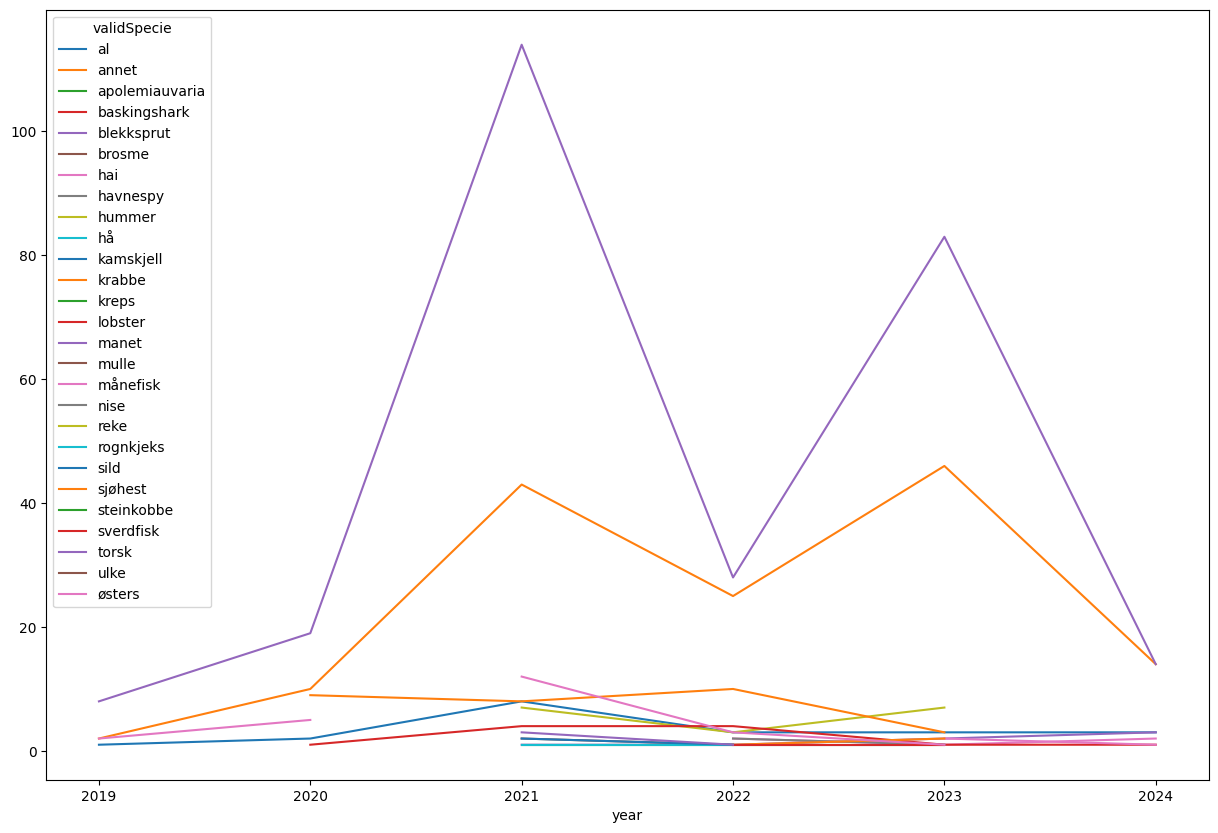

In [269]:
#Group species by year and display as a line graph, ignoring entries before 2017 as they contain very 
# few entries and any conjections made from that data would not be significant.
species_by_year_df = df.groupby(["validSpecie", "year"]).count()
species_by_year_df.reset_index(inplace=True)
species_by_year_df.rename(columns={"isValidated":"amount"}, inplace=True)
species_by_year_df.sort_values(by=['year', 'amount'], inplace=True, ascending=False)

species_by_year_df.drop(species_by_year_df[species_by_year_df.year < 2017].index, inplace=True) #Remove data from before 2017
#print(species_by_year_df)

fig_year, ax_year = plt.subplots(figsize=(15,10))
species_by_year_df.pivot_table("amount", index="year", columns=["validSpecie"]).plot(kind="line" ,ax=ax_year)
fig_year.savefig('year_fig')
plt.show()


   year  amount
0  2024      14
1  2023      83
2  2022      28
3  2021     114
4  2020      19
5  2019       8


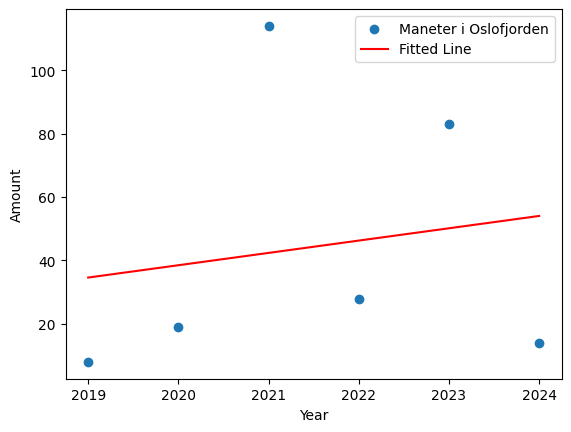

In [270]:
#Linear Regression of Manet population
def fitting(x, m, b):
	return m * x + b

#Create Regression DataFrame for Maneter only
r_df = species_by_year_df.copy()
r_df.drop(r_df[r_df.validSpecie != "manet"].index, inplace=True)
r_df.reset_index(inplace=True)
r_df.drop(labels=["index", "validSpecie"], axis=1, inplace=True)
print(r_df)

params, _ = curve_fit(fitting, r_df['year'], r_df['amount'])
m, b = params

plt.scatter(r_df['year'], r_df['amount'], label="Maneter i Oslofjorden")
x_fit = np.linspace(2019, 2024, 100)
y_fit = fitting(x_fit, m, b)
plt.plot(x_fit, y_fit, color="red", label='Fitted Line')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.show()

